<a href="https://colab.research.google.com/github/FujiminoDeliaMary/ArtfullCode/blob/main/BigDataAI/TP2_nonsupervise_pays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 2 : Réduction de dimensionnalité et clustering
Importation des librairies

In [63]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

# Vérification du dossier courant
import os
print(os.getcwd())

np.set_printoptions(precision=3,suppress=True, threshold=5) # 3 décimales, pas de notation scientifique, affichage de 5 lignes
print(f"Numpy {np.__version__}, Pandas {pd.__version__}")

/content
Numpy 1.26.4, Pandas 2.2.2


# 1/ Réduction des dimensionnalité : PCA et Clustering

1.1 Charger le fichier world-data-2023 dans un dataframe. Afficher les 3 premières lignes.

In [64]:
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/brut-world-data-2023.csv'

df = pd.read_csv(file_path)
df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,"8,672",...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Albania,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,"4,536",...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
2,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,"150,006",...,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626


1.2 Normaliser les données numériques, puis remplacer les valeurs Nan par la valeur 0, en utilisant la fonction np.isnan().

In [65]:

from sklearn.preprocessing import StandardScaler
numeric_cols = df.select_dtypes(include=np.number).columns
scaler = StandardScaler()

df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df = df.fillna(0)

1.3 Appliquer une PCA aux données normalisée, afin d'obtenir une réprésentation en deux dimensions.
En utilisant time, mesure le temps d'éxécution.

In [66]:
from sklearn.decomposition import PCA

#Début du chrono
start_time = time.time()

pca = PCA(n_components=2)
pca_result = pca.fit(df[numeric_cols])
X = pca.transform(df[numeric_cols])

# Fin du chrono
end_time = time.time()

print(f"Temps d'exécution : + {end_time - start_time:.4f} secondes");

Temps d'exécution : + 0.0140 secondes


1.4 Afficher la variance expliquée par les deux axes de la PCA

In [67]:
explained_variance = pca.explained_variance_ratio_
print(f"Variance expliquée par le premier axe : {explained_variance[0]:.4f}")
print(f"Variance expliquée par le deuxième axe : {explained_variance[1]:.4f}")

Variance expliquée par le premier axe : 0.5762
Variance expliquée par le deuxième axe : 0.1389


1.5 Appliquer T-SNE à ces même données toujours en deux dimensions et en affichant le temps de traitement

In [68]:
from sklearn import manifold

start_time = time.time()

tsne = manifold.TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(df[numeric_cols])

end_time = time.time()

print(f"Temps de traitement: + {end_time - start_time:.4f} secondes");

Temps de traitement: + 1.8206 secondes


1.6 Créer deux diagrammes côte côte représentant les pays en 2D suivant les deux algorithmes. Ajouter les noms de pays à chaque point.
Essayer plusieurs paramètres de t-nse pour obtenir un résultat interprétable

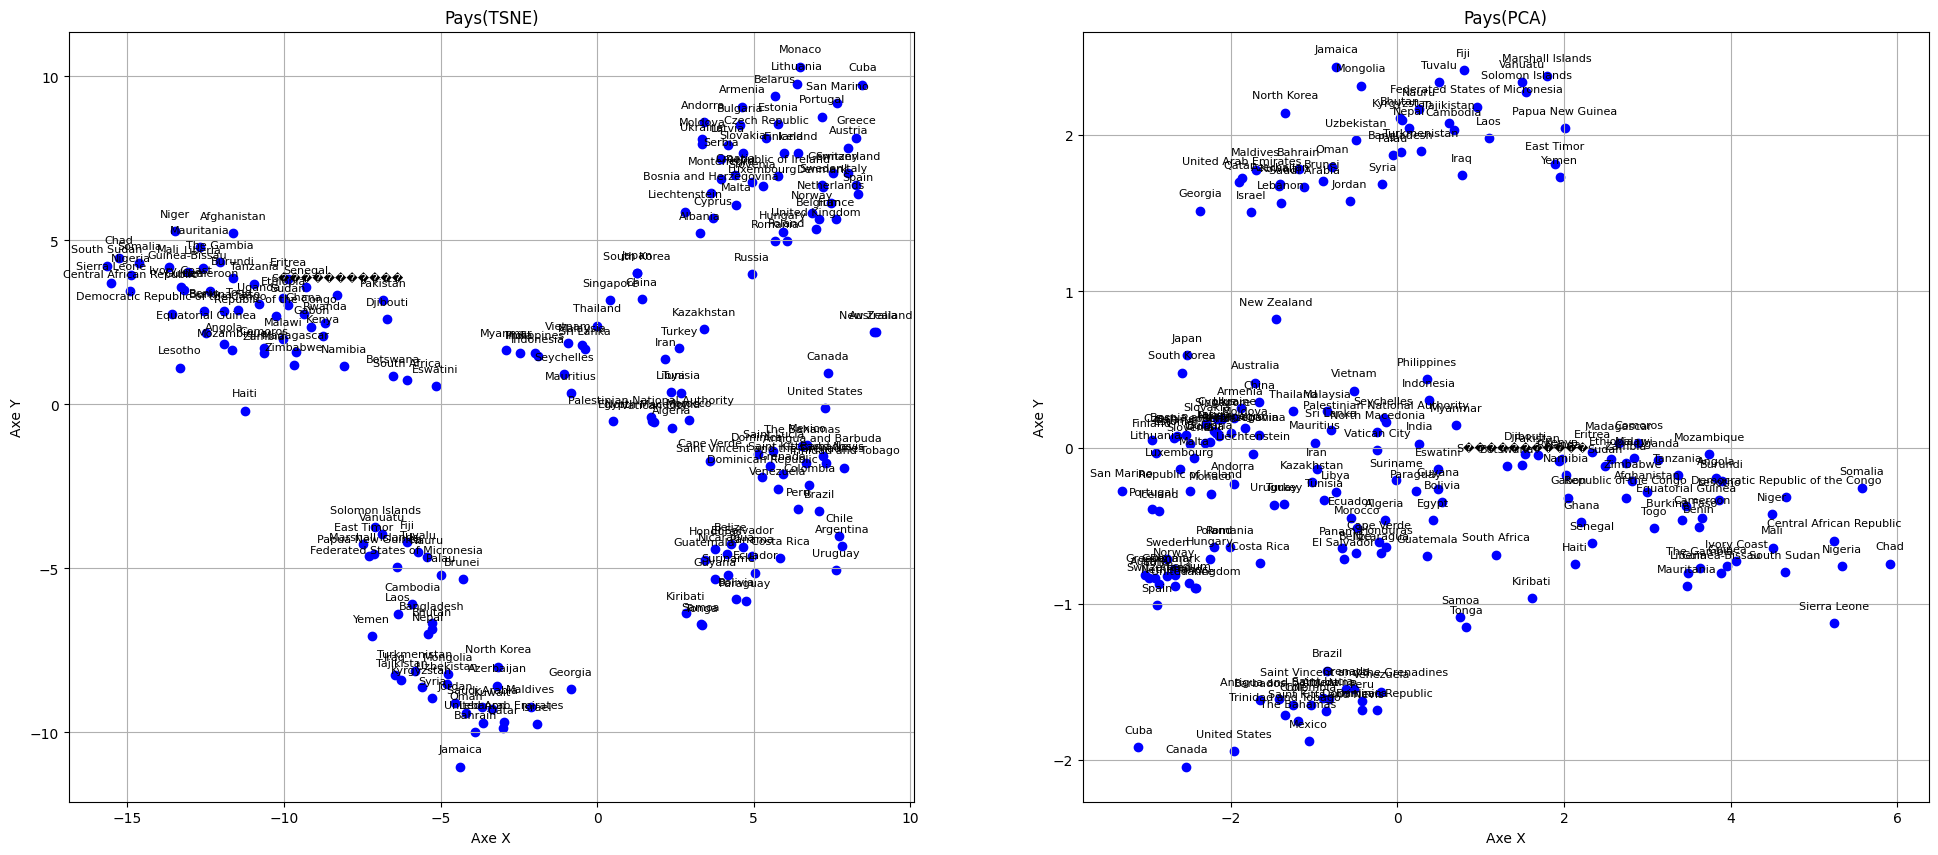

In [69]:
import matplotlib.pyplot as plt
df_countries = df[['Country']]
countries_tsne = tsne_result
countries_pca = X
# Création du double graphique
fig, axs = plt.subplots(1, 2, figsize=(24, 10))  # 1 ligne, 2 colonnes

#TSNE
axs[0].scatter(countries_tsne[:, 0], countries_tsne[:, 1], color='blue')

# Ajout des labels
for i, label in enumerate(df_countries.Country): # Abréviation
    axs[0].annotate(label, (countries_tsne[i, 0], countries_tsne[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')

# Ajout des titres et des axes
axs[0].set_title("Pays(TSNE)")
axs[0].set_xlabel("Axe X")
axs[0].set_ylabel("Axe Y")
axs[0].grid()

#PCA
axs[1].scatter(countries_pca[:, 0], countries_pca[:, 1], color='blue')

# Ajout des labels
for i, label in enumerate(df_countries.Country): # Abréviation
    axs[1].annotate(label, (countries_pca[i, 0], countries_pca[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')

# Ajout des titres et des axes
axs[1].set_title("Pays(PCA)")
axs[1].set_xlabel("Axe X")
axs[1].set_ylabel("Axe Y")
axs[1].grid()
# Afficher le graphique
plt.show()

# 2. Application de K-Means

*2.1* Déterminer le nombre de cluster k-means optimal sur les données initiales normalisées, en traçant une courbe

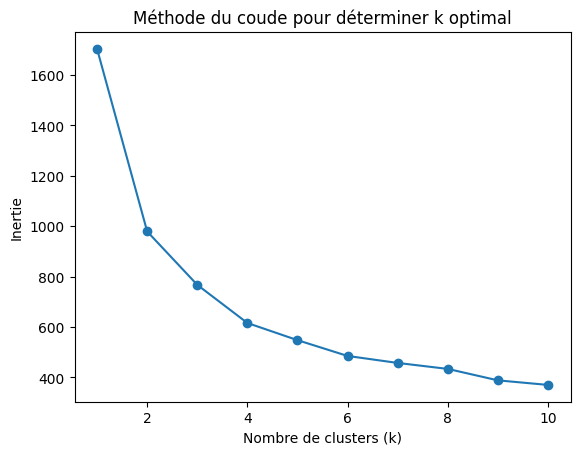

In [70]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[numeric_cols])
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer k optimal')
plt.show()


2.2 Appliquer l'algorithme k-means aux données initiales normalisées, en utilisant le nombre de cluster optimal

Afficher le temps de traitement

In [71]:
from sklearn.cluster import KMeans

start_time = time.time()

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df[numeric_cols])

end_time = time.time()
execution_time_kmeans = end_time - start_time

print(f"Temps d'exécution: {execution_time_kmeans:.4f} secondes")

labels = kmeans.labels_
labels


Temps d'exécution: 0.0160 secondes


array([0, 1, 2, ..., 2, 0, 0], dtype=int32)

2.3 Afficher les pays pour chaque cluster

In [72]:
#Affichage des pays pour chaque cluster
for i in range(optimal_k):
    print(f"Cluster {i}:")
    cluster_countries = df['Country'][labels == i]
    print(cluster_countries.to_string(index=False))
    print("____________________________________")

Cluster 0:
                     Afghanistan
                          Angola
                           Benin
                    Burkina Faso
                         Burundi
                     Ivory Coast
                        Cameroon
        Central African Republic
                            Chad
                         Comoros
           Republic of the Congo
Democratic Republic of the Congo
               Equatorial Guinea
                         Eritrea
                        Ethiopia
                           Gabon
                      The Gambia
                           Ghana
                          Guinea
                   Guinea-Bissau
                           Haiti
                           Kenya
                         Lesotho
                         Liberia
                      Madagascar
                          Malawi
                            Mali
                      Mauritania
                      Mozambique
                         Namibia

2.4 Tracer en 2D avec t-sne et pca les données avec une couleur par cluster k-means.

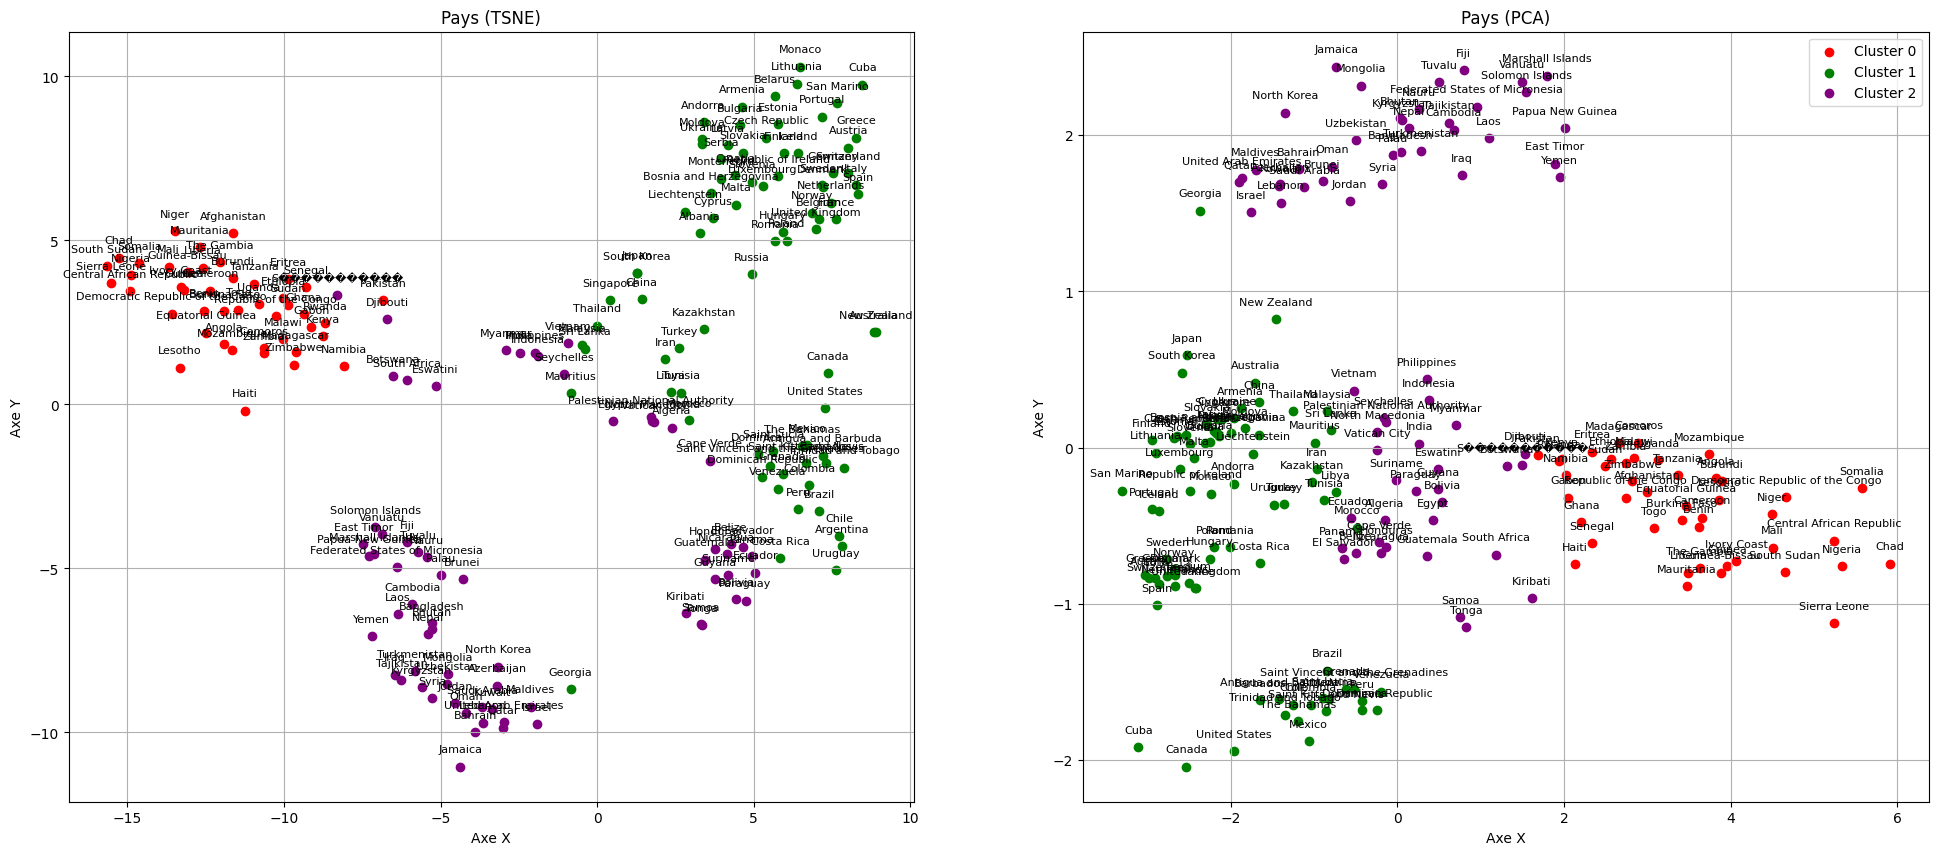

In [73]:

clusters_kmeans = labels

# Liste de couleurs à utiliser pour les clusters (une couleur par cluster)
colors = ['red', 'green', 'purple']

# Création du double graphique
fig, axs = plt.subplots(1, 2, figsize=(24, 10))  # 1 ligne, 2 colonnes

# Graphique TSNE
for cluster_value in np.unique(clusters_kmeans):
    cluster_points = countries_tsne[clusters_kmeans == cluster_value]
    axs[0].scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_value], label=f'Cluster {cluster_value}')
# Ajout des labels
for i, label in enumerate(df_countries.Country):
    axs[0].annotate(label, (countries_tsne[i, 0], countries_tsne[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')
# Ajout des titres et des axes
axs[0].set_title("Pays (TSNE)")
axs[0].set_xlabel("Axe X")
axs[0].set_ylabel("Axe Y")
axs[0].grid()

# Graphique PCA
for cluster_value in np.unique(clusters_kmeans):
    cluster_points = countries_pca[clusters_kmeans == cluster_value]
    axs[1].scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_value], label=f'Cluster {cluster_value}')
# Ajout des labels
for i, label in enumerate(df_countries.Country):
    axs[1].annotate(label, (countries_pca[i, 0], countries_pca[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')
# Ajout des titres et des axes
axs[1].set_title("Pays (PCA)")
axs[1].set_xlabel("Axe X")
axs[1].set_ylabel("Axe Y")
axs[1].grid()

# Afficher le graphique
plt.legend()
plt.show()

2.5 Réafficher La projection PCA en excluant les plus grands pays : China, United States, India, Russia

Interpréter les axes X et Y de la PCA.

<ipython-input-78-156647b4e8fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_countries['cluster'] = clusters_kmeans


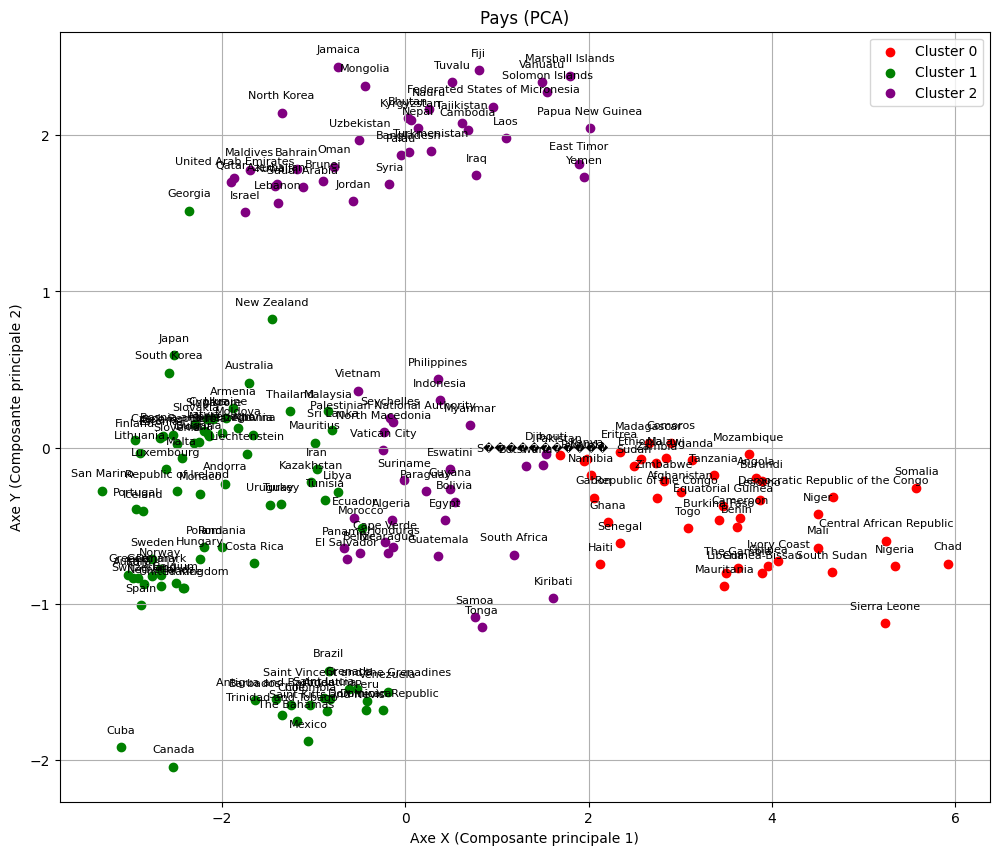

In [78]:

df_countries['cluster'] = clusters_kmeans
excluded_countries = ['China','United States','India','Russia']
countries_filtered = countries_pca[~df_countries.Country.isin(excluded_countries)]
plt.figure(figsize=(12, 10))
for cluster_value in np.unique(clusters_kmeans):
    cluster_points = countries_filtered[df_countries.loc[~df_countries.Country.isin(excluded_countries),'cluster'] == cluster_value]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_value], label=f'Cluster {cluster_value}')

# Ajout des labels
for i, label in enumerate(df_countries.loc[~df_countries.Country.isin(excluded_countries),'Country']):
    plt.annotate(label, (countries_filtered[i, 0], countries_filtered[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')

# Ajout des titres et des axes
plt.title("Pays (PCA)")
plt.xlabel("Axe X (Composante principale 1)")
plt.ylabel("Axe Y (Composante principale 2)")
plt.grid()

# Afficher le graphique
plt.legend()
plt.show()


# 3. Application de CAH

3.1 Importation des librairies

In [80]:
from sklearn.metrics import accuracy_score # Calcul du score de bonnes réponses
from scipy.spatial.distance import pdist # Fonction scipy de création de la CAH de calcul des distances
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster # Fonction scipy de création de la CAH

3.2 Afficher la matrice de linkage des données de pays

Mesurer le temps de traitement

In [83]:
import time

t0 = time.time()

Z = linkage(X, metric='euclidean', method='ward')

temps_traitement = time.time() - t0

print(f"Temps de traitement: {round(temps_traitement, 4)} s")

df_linkage = pd.DataFrame(Z, columns=['Noeud 1', 'Noeud 2', 'distance', "nombre d'exemple"])
df_linkage[['Noeud 1', 'Noeud 2', "nombre d'exemple"]] = df_linkage[['Noeud 1', 'Noeud 2', "nombre d'exemple"]].astype(int)

print(df_linkage)


Temps de traitement: 0.0024 s
     Noeud 1  Noeud 2   distance  nombre d'exemple
0         60      185   0.012605                 2
1         21      153   0.019586                 2
2         10       90   0.024564                 2
3         93      143   0.026692                 2
4         19       91   0.033239                 2
..       ...      ...        ...               ...
189      374      380   8.627925                38
190      375      382   9.472721                51
191      381      383  14.043542               106
192      384      386  20.749926               144
193      385      387  37.063320               195

[194 rows x 4 columns]


3.3 Afficher horizontalement le dentogramme complet.

Mesurer le temps de traitement

Temps de traitement pour le dendrogramme complet : 0.4631 secondes.


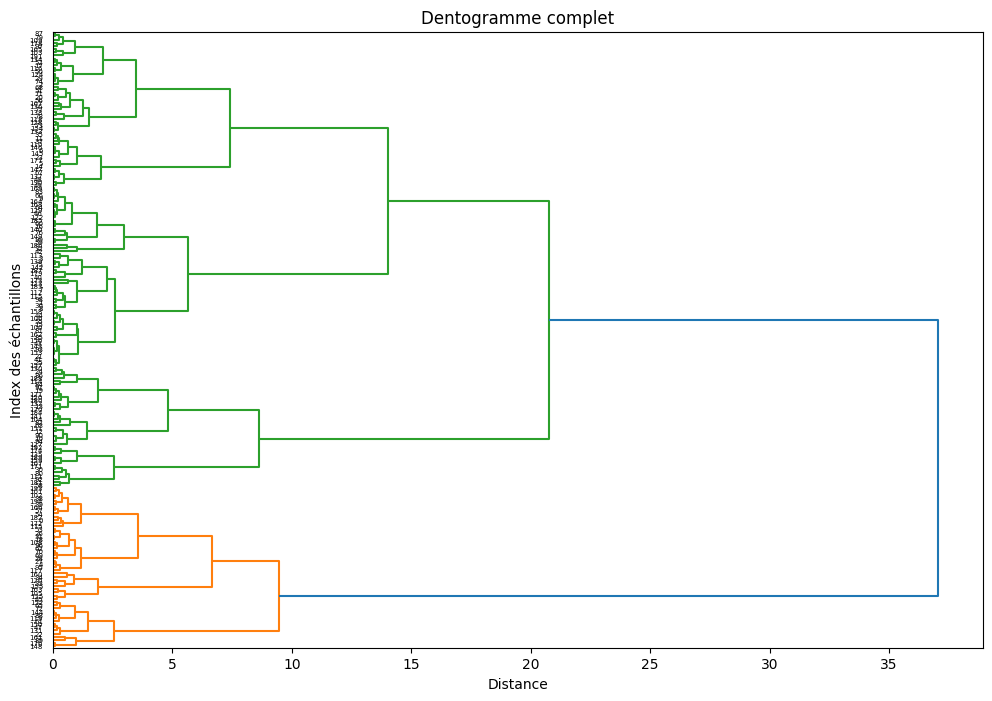

In [87]:
t0 = time.time()

plt.figure(figsize=(12, 8))

dendrogram(Z, orientation='right')

plt.title("Dentogramme complet")
plt.xlabel("Distance")
plt.ylabel("Index des échantillons")

temps_traitement = time.time() - t0
print(f"Temps de traitement pour le dendrogramme complet : {round(temps_traitement, 4)} secondes.")

plt.show()

3.4 Afficher les 4 niveaux supérieurs du dentogramme

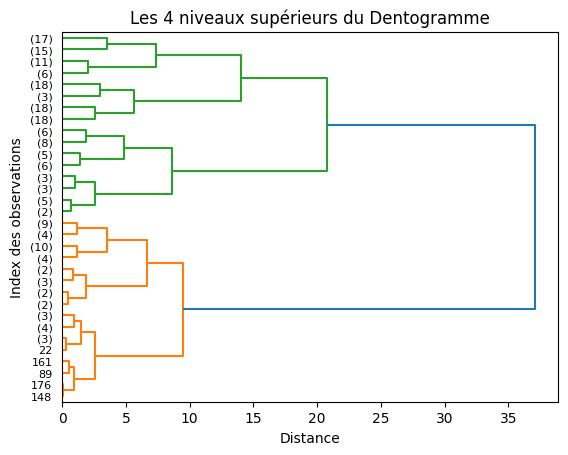

In [86]:
dendrogram(Z, orientation='right', truncate_mode='level', p=4)

plt.title("Les 4 niveaux supérieurs du Dentogramme")
plt.xlabel("Distance")
plt.ylabel("Index des observations")

plt.show()

3.5 Trouver le nombre optimal de cluster CAH

[0, 0.3139530030557827, 0.4897198135011191, 0.6086787259169449, 0.6889194961619498, 0.7620042286637121, 0.8246909709753072, 0.8809885916036834, 0.9290147200633416, 0.9698693688278986]


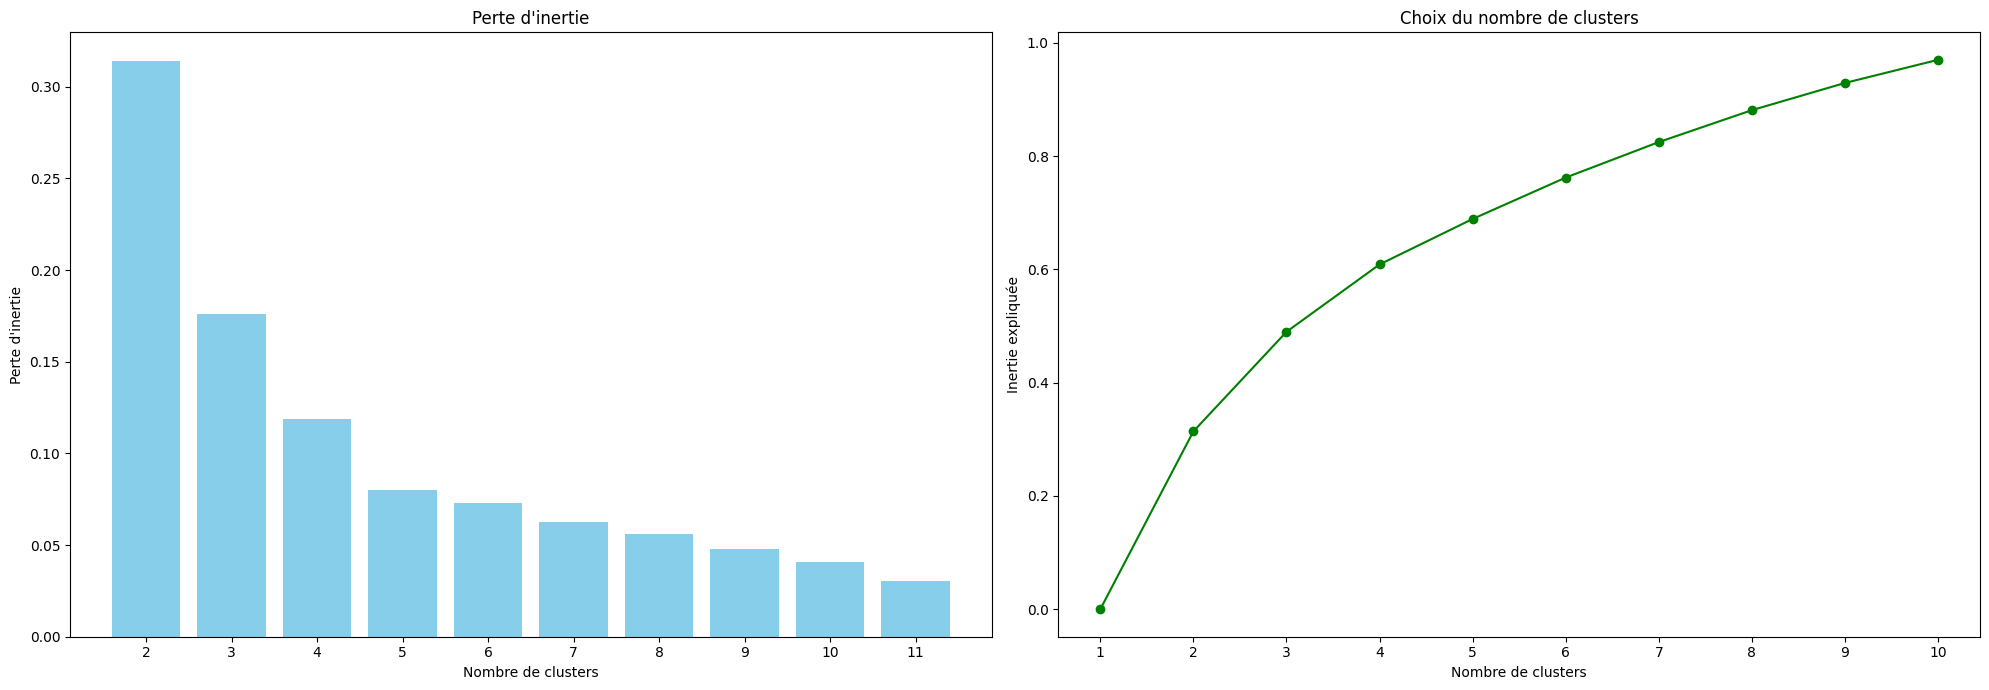

In [88]:
total_inertia = Z[-10:, 2].sum()
last = Z[-10:, 2]
inertia_loss = np.flip(last, 0) / total_inertia

explained_inertia = [0]
for nb_cluster in range(2, 11):
    explained_inertia.append(explained_inertia[-1] + inertia_loss[nb_cluster - 2])

print(explained_inertia)


# Création des graphiques
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# Graphique 1 : Perte d'inertie
axs[0].bar(range(2, len(inertia_loss) + 2), inertia_loss, color='skyblue')
axs[0].set_title("Perte d'inertie")
axs[0].set_xlabel("Nombre de clusters")
axs[0].set_xticks(range(2, 12, 1))
axs[0].set_ylabel("Perte d'inertie")

# Graphique 2 : Inertie expliquée
axs[1].plot(range(1, len(explained_inertia) + 1), explained_inertia, marker='o', color='green')
axs[1].set_title("Choix du nombre de clusters")
axs[1].set_xlabel("Nombre de clusters")
axs[1].set_xticks(range(1, 11, 1))
axs[1].set_ylabel("Inertie expliquée")

plt.tight_layout()
plt.show()

3.6 Diviser selon le nombre optimal de cluster obtenu. Afficher la liste de pays de chaque cluster.

In [90]:
from scipy.cluster.hierarchy import fcluster

optimal_k = 3

clusters_cah = fcluster(Z, optimal_k, criterion='maxclust')

df_countries['Cluster_CAH'] = clusters_cah

for cluster in sorted(df_countries['Cluster_CAH'].unique()):
    countries_list = df_countries[df_countries['Cluster_CAH'] == cluster]['Country'].tolist()
    print(f"Cluster {cluster} :")
    print(", ".join(countries_list))
    print('----------------------')

Cluster 1 :
Afghanistan, Angola, Benin, Botswana, Burkina Faso, Burundi, Ivory Coast, Cameroon, Central African Republic, Chad, Comoros, Republic of the Congo, Democratic Republic of the Congo, Djibouti, Equatorial Guinea, Eritrea, Ethiopia, Gabon, The Gambia, Ghana, Guinea, Guinea-Bissau, Haiti, Kenya, Kiribati, Lesotho, Liberia, Madagascar, Malawi, Mali, Mauritania, Mozambique, Namibia, Niger, Nigeria, Pakistan, Rwanda, Samoa, S�����������, Senegal, Sierra Leone, Somalia, South Africa, South Sudan, Sudan, Tanzania, Togo, Tonga, Uganda, Zambia, Zimbabwe
----------------------
Cluster 2 :
Azerbaijan, Bahrain, Bangladesh, Bhutan, Brunei, Cambodia, Fiji, Georgia, Iraq, Israel, Jamaica, Jordan, Kuwait, Kyrgyzstan, Laos, Lebanon, Maldives, Marshall Islands, Federated States of Micronesia, Mongolia, Nauru, Nepal, North Korea, Oman, Palau, Papua New Guinea, Qatar, Saudi Arabia, Solomon Islands, Syria, Tajikistan, East Timor, Turkmenistan, Tuvalu, United Arab Emirates, Uzbekistan, Vanuatu, Ye

<ipython-input-90-321fe78893ad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_countries['Cluster_CAH'] = clusters_cah


3.7 Tracer en 2D avec t-sne et pca les données avec une couleur par cluster CAH.

3.8 Afficher la projection PCA en retirant les plus grands pays : China, United States, India et Russia

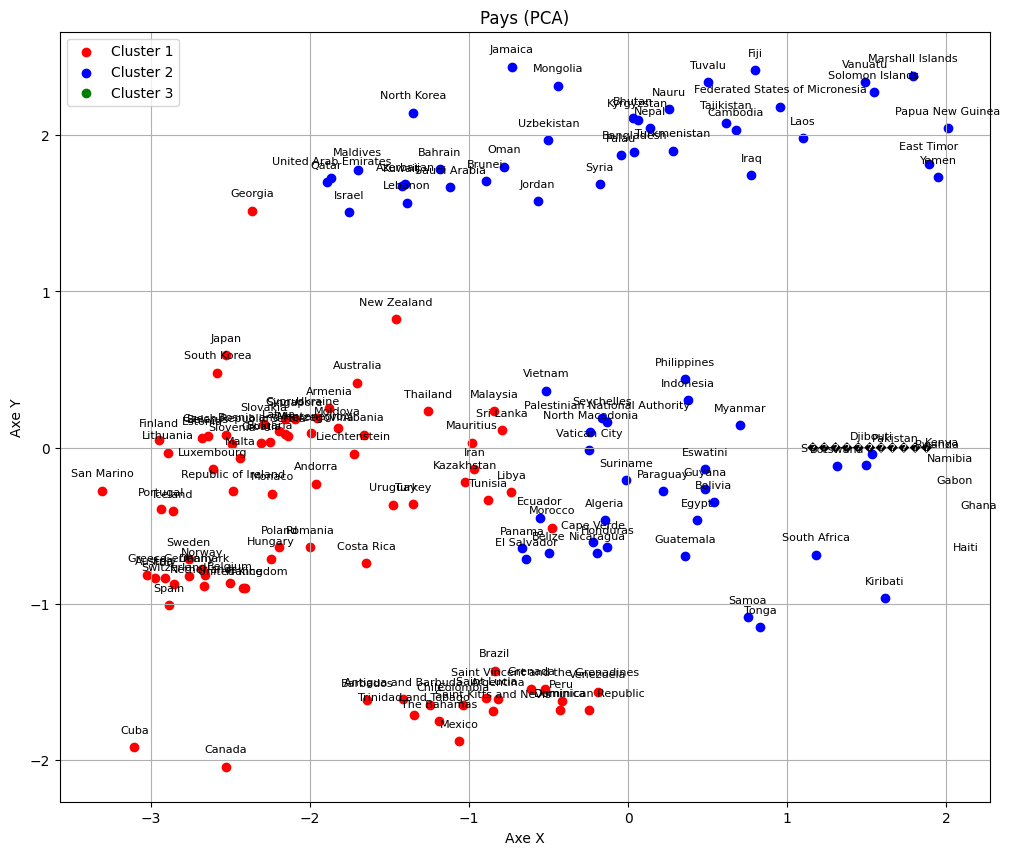

In [96]:

excluded_countries = ['China','United States','India','Russia']
countries_filtered = countries_pca[~df_countries.Country.isin(excluded_countries)]
plt.figure(figsize=(12, 10))
for cluster_value in np.unique(clusters_cah):
    cluster_points = countries_filtered[df_countries.loc[~df_countries.Country.isin(excluded_countries),'cluster'] == cluster_value]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_value-1], label=f'Cluster {cluster_value}')
# Ajout des labels
for i, label in enumerate(df_countries.loc[~df_countries.Country.isin(excluded_countries),'Country']):
    plt.annotate(label, (countries_filtered[i, 0], countries_filtered[i, 1]), textcoords="offset points", xytext=(0,10), fontsize = 8, ha='center')
# Ajout des titres et des axes
plt.title("Pays (PCA)")
plt.xlabel("Axe X")
plt.ylabel("Axe Y")
plt.grid()

# Afficher le graphique
plt.legend()
plt.show()

3.9 Quels sont les avantages et inconvénient entre les différentes combinaisons de réduction de dimensionnalité (PCA, t-SNE) et de clustering (k-Means, CAH) ?

<i>écrivez votre réponse ici</i>